<a href="https://colab.research.google.com/gist/dshulchevskii/78b8a0ac846a94e4c058bb9c6ce0dfc7/2024-03-05-ab-hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задача 1 (1 балл)

Руководитель продукта, у которого имеется АБ-платформа, хочет выяснить, стоит ли инвестировать ресурсы в ускорение своего продукта. Как ему сделать это с минимальными трудозатратами?

Можно предложить следующий план действий:

1. Анализ существующих данных и метрик эффективности и скорости продукта: данные о времени загрузки страниц, времени ответа сервера, скорости выполнения операций и другие показатели, которые могут указать на необходимость ускорения.

2. Определение ключевых областей для ускорения: на основе анализа данных можно выявить ключевые области продукта, где улучшение производительности может оказать наибольшее влияние на пользовательский опыт. Например, узкие места в коде, медленные запросы к базе данных и т.д. (например, в NewRelic можно разрезать на кусочки все действия контроллера и проанализировать, что там вызывает наибольшие задержки)

3. Ищем похожие эксперименты в истории АБ платформы, чтобы не привлекать дополнительные ресурсы, а также, если есть такая информация, показатели у других компаний на рынке (можно также эмпирическим путем сравнить некоторые метрики, например, как долго загружается страница у нас и у конкурента). 

Если информации все еще недостаточно для принятия решения:

4. Оценка возможных улучшений и инвестиций: это может включать в себя оценку стоимости, времени и трудозатрат, необходимых для ускорения продукта. Формулирование гипотез для АБ тестов согласно выбранным улучшениям.

5. Разработка теста: проведение эксперимента, где одной группе пользователей представляется текущая версия продукта, а другой - ускоренная версия.

6. Сбор и анализ данных: смотрим показатели метрик, проводим статистический анализ.

7. Коллективное обсуждение и принятие решения: после всех оценок и анализа данных, руководитель продукта может обсудить результаты с командой разработки, техническими специалистами и решить вопрос о необходимости и оправданности инвестиций в улучшение производительности продукта (в целом, если в штате есть опытные сотрудники, связанные с темой продукта, можно сначала для экономии времени и сил обратиться к ним, чтобы они сказали, на какие метрики первым делом стоит обратить внимание, а какие некритичны).

Эти шаги помогут руководителю продукта принять обоснованное решение о целесообразности инвестиций в ускорение продукта с минимальными трудозатратами.

## Задача 2 (2 балла)

Аналитик решил протестировать два вида баннеров A и B. По ходу АБ-эксперимента по n пользователей увидело баннер А и B. В группе A конверсия составила 56%, а в группе B 59%. При каких n можно считать, что в группе B на уровне значимости в 0.1% действительно выше конверсия?

In [1]:
import math
import scipy.stats
from scipy.stats import norm

def calculate_z_value(p1, p2, n1, n2):
    p = (p1 * n1 + p2 * n2) / (n1 + n2)
    se = math.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))
    z = (p2 - p1) / se
    return z

def calculate_sample_size(p1, p2, alpha):
    z_alpha = abs(norm.ppf(1-alpha))  # Односторонний тест: H0: conv_B = conv_A, H1: conv_B > conv_A
    n = ((z_alpha * math.sqrt(p1 * (1 - p1) + p2 * (1 - p2))) / (p2 - p1))**2 # Вывела из формулы
    return n

# Конверсии групп A и B
n = 1000
conv_A = 0.56
conv_B = 0.59
# Уровень значимости
alpha = 0.001
n_A = n // 2  # Предполагаем, что пользователи равномерно распределялись между группами
n_B = n - n_A

# Рассчитываем z-значение
z_value = calculate_z_value(conv_B, conv_A, n_B, n_A)

# Рассчитываем необходимый размер выборки
sample_size = calculate_sample_size(conv_B, conv_A, alpha)

print(f"Z-значение: {z_value}")
print(f"Необходимый размер выборки: {sample_size}")


Z-значение: -0.9595395315107992
Необходимый размер выборки: 5181.153650311635


## Задача 3 (3 балла)
Аналитик собирается провести эксперимент с добавлением фичи на 14 дней с p-value 5%. То есть в 5% случаев, если на самом деле нет изменений, то фичу будут выкатывать. Аналитик очень нетерпеливый, и любит подглядывать (рассчитывает стат. значимость каждый день эксперимента). Как только в какой-то день p-value оказывается ниже 5%, он собирается остановить эксперимент и выкатить фичу.

* Посчитайте 99% доверительный интервал для количества AA экспериментов из 1000, которые должны иметь p-value 5%. (1 балл)
* Посчитайте на синтетическом примере в какой доле AA экспериментов аналитик отвергнет нулевую гипотезу, если будет подглядывать. Другими словами какая реальная ошибка первого рода. (1 балл)
* Какое p-value нужно использовать при "подглядывании", чтобы итоговая ошибка первого рода составила 5%? (1 балл)

0.063

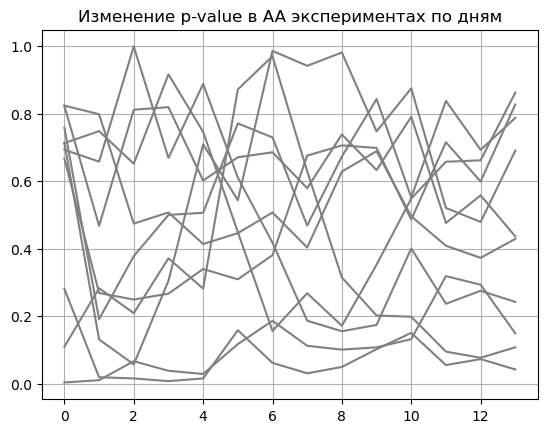

In [2]:
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np

p_value_bound = 0.05
np.random.seed(182)

def generate_p_values_by_day(N=1000, samples_per_day=100, days=14):
    data = []

    for i in range(N):
        test = np.array([])
        control = np.array([])
        p_values = []
        for day in range(days):
            test = np.hstack([test, np.random.randn(samples_per_day)])
            control = np.hstack([control, np.random.randn(samples_per_day)])
            p_value = ttest_ind(test, control, equal_var=False).pvalue
            p_values.append(p_value)
        data.append(p_values)

    return pd.DataFrame(data).T

df = generate_p_values_by_day()
df[list(range(10))].plot(legend=False, color='grey', grid=True, title='Изменение p-value в AA экспериментах по дням')
(df.loc[13] < p_value_bound).sum() / df.shape[1]

В примере выше запускается 1000 AA экспериментов. В 0.063 доле случаев на 14 день p-value оказывается меньше 5%.

In [3]:
# пункт а
# Для решения этой задачи мы можем использовать биномиальное распределение, т.к. у нас бинарные события (выкатываем/не выкатываем). 
# При этом из условия задачи мы знаем: вероятность того, что мы выкатываем фичу равна 5%.
# Много наблюдений => по ЦПТ стремимся к нормальному
# Данные задачи
p = 0.05
n = 1000
alpha = 0.01

# Среднее и стандартное отклонение распределения Бернулли
mean = n * p
std_dev = math.sqrt(n * p * (1 - p))

# Значение Z для 99% доверительного интервала
z = abs(norm.ppf(alpha / 2))

# Рассчитываем границы доверительного интервала
lower_bound = mean - z * std_dev
upper_bound = mean + z * std_dev

lower_bound, upper_bound

(32.24732165140968, 67.75267834859032)

In [4]:
df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.712647,0.280851,0.003298,0.692994,0.109240,0.823772,0.822744,0.666948,0.758624,0.713329,...,0.983282,0.704380,0.164442,0.428754,0.978564,0.928768,0.587519,0.379916,0.021721,0.113574
1,0.748329,0.018854,0.010063,0.657788,0.282775,0.798428,0.467493,0.268609,0.190828,0.130919,...,0.775465,0.521478,0.516597,0.764601,0.943025,0.772872,0.218248,0.398501,0.034081,0.102878
2,0.651636,0.015274,0.066314,0.999138,0.208712,0.474203,0.811732,0.248974,0.377670,0.056954,...,0.734879,0.384807,0.602616,0.267744,0.668610,0.812308,0.397419,0.215488,0.110485,0.162522
3,0.916442,0.007259,0.037963,0.668643,0.371285,0.507270,0.819318,0.266567,0.499914,0.304665,...,0.996303,0.456238,0.945940,0.302651,0.248572,0.590481,0.098556,0.274605,0.189682,0.340362
4,0.746245,0.015253,0.028504,0.888135,0.281548,0.413670,0.601744,0.339683,0.506309,0.709104,...,0.618336,0.636096,0.757605,0.291441,0.200536,0.403013,0.126303,0.333868,0.633269,0.247989
5,0.449031,0.158177,0.116962,0.610748,0.871860,0.445841,0.670740,0.309028,0.771078,0.543446,...,0.576732,0.669644,0.678072,0.259741,0.400992,0.311263,0.037311,0.228095,0.903000,0.165543
6,0.156055,0.061438,0.186177,0.417511,0.970246,0.507041,0.685552,0.380711,0.729594,0.986154,...,0.916050,0.908113,0.928196,0.248840,0.400260,0.497379,0.100559,0.116818,0.734305,0.395091
7,0.267728,0.030453,0.112048,0.186278,0.629266,0.403350,0.579090,0.675628,0.468509,0.941774,...,0.941887,0.934774,0.810430,0.224407,0.670964,0.545602,0.128103,0.039551,0.830057,0.500607
8,0.171513,0.049301,0.100641,0.155234,0.314490,0.628347,0.738301,0.705907,0.673013,0.981352,...,0.554572,0.921464,0.752465,0.229677,0.826924,0.699335,0.078865,0.018665,0.673512,0.969626
9,0.352332,0.101889,0.107457,0.173839,0.201891,0.688775,0.632826,0.698403,0.843399,0.747548,...,0.830464,0.993647,0.763359,0.371434,0.528739,0.894371,0.077368,0.006906,0.693876,0.993936


In [5]:
# пункт б
f = []
for s in range(1000): # Цикл для перебора столбцов
    column_values = df[s].values # Из каждого столбца вытаскиваем значения для каждого дня
    
    # Присваиваем 1, если нулевая гипотеза в конкретный день отвергается
    results = [1 if np.any(value < p_value_bound) else 0 for value in column_values] 
    f.append(int(np.where(1 in results, 1, 0))) 
print(f"Ошибка первого рода без корректировки при подглядывании: {sum(f)/len(f)}")



Ошибка первого рода без корректировки при подглядывании: 0.244


Видим ошибку 1 рода больше 0.05 из-за подглядывания. Смысл в том, что значение p-value по ходу теста может случайно опускаться ниже принятого уровня значимости. Если внимательно следить за экспериментом, то можно поймать такой момент и ошибочно сделать вывод о статистической значимости.

In [6]:
# пункт в
# https://habr.com/ru/articles/556852/
fb = []
for s in range(1000): # Цикл для перебора столбцов
    column_values = df[s].values
    results = [1 if np.any(value < p_value_bound/14) else 0 for value in column_values]
    fb.append(int(np.where(1 in results, 1, 0)))
print(f"Ошибка первого рода c поправкой Бонферрони: {sum(fb)/len(f)}")

Ошибка первого рода c поправкой Бонферрони: 0.026


Применила поправку Бонферрони для смягчения увеличения вероятности совершения ошибки 1-го рода при многократной проверке.

## Задача 4 (3 балла)
Будем называть чувствительностью метрики долю экспериментов со стат. значимым изменением метрики. В синтетическом примере ниже среди 1000 AB тестов метрика количества действий на пользователя прокрашивается в 15.8% случаев на уровне значимости 5%. В сгенерированных данных также присутствуют данные до эксперимента по каждому пользователю (time_interval = 'before_exp').

* Проверьте, что в AA тестах (когда эффект нулевой) красятся около 5% экспериментов. (1 балл)
* Постройте корректную метрику с большей чувствительностью и оцените чувствительность. (2 балл)

In [7]:
def generate_data(N=50, effect=1):
    hidden_users_param_control = 5 * np.random.exponential(size=N)
    hidden_users_param_test = 5 * np.random.exponential(size=N)

    return (
        pd.DataFrame({
            'sample_group': np.hstack([
                np.repeat('control', N),
                np.repeat('control', N),
                np.repeat('test', N),
                np.repeat('test', N),
            ]),
            'time_interval': np.hstack([
                np.repeat('before_exp', N),
                np.repeat('exp', N),
                np.repeat('before_exp', N),
                np.repeat('exp', N),
            ]),
            'user_id': np.hstack([
                np.arange(N),
                np.arange(N),
                np.arange(N, 2 * N),
                np.arange(N, 2 * N)
            ]),
            'actions': np.random.poisson(np.hstack([
                hidden_users_param_control,
                hidden_users_param_control,
                hidden_users_param_test,
                hidden_users_param_test + effect,
            ]))
        })
    )

def calc_sensitivity(exp_count=1000, p_value=0.05, effect=1, seed=182):
    np.random.seed(seed)
    p_values = []
    for _ in range(exp_count):
        data = generate_data(effect=effect)
        test_metric = data.query('time_interval == "exp" and sample_group == "test"')['actions']
        control_metric = data.query('time_interval == "exp" and sample_group == "control"')['actions']
        p_values.append(ttest_ind(test_metric, control_metric, equal_var=False).pvalue)
    return sum(p < p_value for p in p_values) / exp_count

calc_sensitivity(effect=1)

0.158

In [8]:
# Рассчитываем чувствительность для АА тестов (при нулевом эффекте)
print(calc_sensitivity(effect=0))

0.056


In [9]:
# Проверяем для других зерен
print(calc_sensitivity(effect=0, seed = 1))
print(calc_sensitivity(effect=0, seed = 117))
print(calc_sensitivity(effect=0, seed = 15))

0.055
0.051
0.05


В AA тестах (когда эффект нулевой) красятся около 5% экспериментов.

Вместо ttest использовала тест Манна-Уитни,что увеличило чувствительность АБ тестов с 15.8% до 28.1%

In [10]:
from scipy.stats import mannwhitneyu
def calc_sensitivity_mw(exp_count=1000, p_value=0.05, effect=1, seed=182):
    np.random.seed(seed)
    p_values = []
    for _ in range(exp_count):
        data = generate_data(effect=effect)
        test_metric = data.query('time_interval == "exp" and sample_group == "test"')['actions']
        control_metric = data.query('time_interval == "exp" and sample_group == "control"')['actions']
        p_values.append(mannwhitneyu(test_metric, control_metric).pvalue)
    return sum(p < p_value for p in p_values) / exp_count

calc_sensitivity_mw(effect=1)

0.281

In [11]:
# Проверяем, что в AA тестах (когда эффект нулевой) красятся около 5% экспериментов.
calc_sensitivity_mw(effect=0)

0.046

In [12]:
# Проверяем для других зерен
print(calc_sensitivity_mw(effect=0, seed = 1))
print(calc_sensitivity_mw(effect=0, seed = 117))

0.056
0.057


Чтобы увеличить чувствительность АБ тестов воспользовалась методом уменьшения вариации CUPED.

In [13]:
def cuped_ttest(control, test, control_before, test_before):
    theta = (np.cov(control, control_before)[0,1] + np.cov(test, test_before)[0,1]) /\
                (np.var(control_before) + np.var(test_before))

    control_cup = [x - theta*y for x, y in zip(list(control), list(control_before))]
    test_cup = [x - theta*y for x, y in zip(list(test), list(test_before))]
    return ttest_ind(control_cup, test_cup)

In [14]:
def calc_cuped_sensitivity(exp_count=1000, p_value=0.05, effect=1, seed=182):
    np.random.seed(seed)
    p_values = []
    for _ in range(exp_count):
        data = generate_data(effect=effect)
        test = list(data.query('time_interval == "exp" and sample_group == "test"')['actions'])
        control = list(data.query('time_interval == "exp" and sample_group == "control"')['actions'])
        control_before = list(data.query('time_interval == "before_exp" and sample_group == "control"')['actions'])
        test_before = list(data.query('time_interval == "before_exp" and sample_group == "test"')['actions'])
        p_values.append(cuped_ttest(control, test, control_before, test_before).pvalue)
    return sum(p < p_value for p in p_values) / exp_count

calc_cuped_sensitivity(effect=1)

0.38

In [15]:
# Проверяем, что в AA тестах (когда эффект нулевой) красятся около 5% экспериментов.
calc_cuped_sensitivity(effect=0)

0.051

In [16]:
# Проверяем для других зерен
print(calc_cuped_sensitivity(effect=0, seed = 1))
print(calc_cuped_sensitivity(effect=0, seed = 117))
print(calc_cuped_sensitivity(effect=0, seed = 15))

0.052
0.052
0.055


In [17]:
# https://habr.com/ru/companies/avito/articles/571096/ CUPED

Чувствительность АБ тестов после применения CUPED увеличилась с 15.8% до 38%